<a href="https://colab.research.google.com/github/oliveiraruiz/Intro_Ciencia_Dados_2021/blob/main/ICD_T2_Jo%C3%A3o_Ruiz_Carlos_Yoshiga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabalho T2 Introdução a Ciência de Dados
Carlos Henrique Polo Yoshiga RA 21.84427-5

João de Oliveira Ruiz RA 21.84400-3

Problema: determinar qual é o modelo com maior nível de precisão que consiga determinar se vai chover ou não no dia seguinte, na Austrália. Para isso, utilizamos a limpeza, modelagem do problema, e utilização do Auto ML para a escolha do melhor modelo.

#Dados iniciais e origem do dataframe

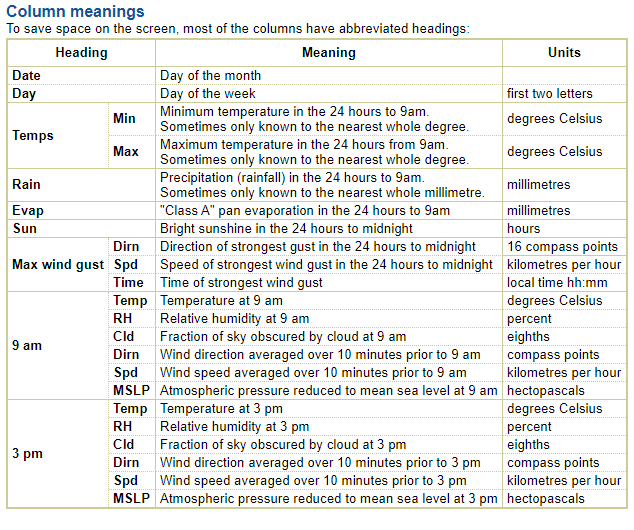

http://www.bom.gov.au/climate/data/

#Download do dataframe

In [8]:
# Baixa o csv a partir de um link para que qualquer pessoa possa executar sem maiores dificuldades
# Uniformiza o trabalho e facilita o compartilhamento de códigos e notebooks
# Realiza o download dos dados e extrai para uma pasta conhecida
import pandas as pd
import zipfile
import gdown
import os
import plotly.express as px
!gdown --id 10WN9t9eS2NuBEVLryWMd2Wpf4qPsanbm
df_rain_original = pd.read_csv('weatherAUS_V2.csv')

Downloading...
From: https://drive.google.com/uc?id=10WN9t9eS2NuBEVLryWMd2Wpf4qPsanbm
To: /content/weatherAUS_V2.csv
15.3MB [00:00, 135MB/s]


###Cópia do dataframe principal

In [9]:
df_rain_alterado = df_rain_original.copy()

###Inserindo dados de zonas climáticas e precipitação média anual por cidade

In [10]:
!gdown --id 1m_RtXazS-uxZ3KDaSIE9THFmaXAW3JL0
df_clima = pd.read_csv( 'climatebycity.CSV', sep = ';')
df_rain_alterado = df_rain_alterado.merge(df_clima,how='left')

Downloading...
From: https://drive.google.com/uc?id=1m_RtXazS-uxZ3KDaSIE9THFmaXAW3JL0
To: /content/climatebycity.CSV
100% 1.28k/1.28k [00:00<00:00, 2.25MB/s]


###Criação das colunas com a transformação da velocidade do vento e direção em vetores X e Y. A adição destas variáveis não melhorou o modelo, mas decidimos deixar para registrar o desenvolvimento

In [11]:
!gdown --id 1iA02y41ad_0tiWX0KYARq-gMhQYPgfmE
df_WindGustDir = pd.read_csv( 'WindGustDir.csv', sep = ';')
df_rain_alterado = df_rain_alterado.merge(df_WindGustDir,how='left')
df_rain_alterado['WindGustDirX'] = df_rain_alterado.WindGustDirX * df_rain_alterado.WindGustSpeed
df_rain_alterado['WindGustDirY'] = df_rain_alterado.WindGustDirY * df_rain_alterado.WindGustSpeed

!gdown --id 1RyzDBVhdWsGHIYxsT4jCrBM-1zcnwgdi
df_WindDir9am = pd.read_csv( 'WindDir9am.csv', sep = ';')
df_rain_alterado = df_rain_alterado.merge(df_WindDir9am,how='left')
df_rain_alterado['WindDir9amX'] = df_rain_alterado.WindDir9amX * df_rain_alterado.WindGustSpeed
df_rain_alterado['WindDir9amY'] = df_rain_alterado.WindDir9amY * df_rain_alterado.WindGustSpeed

!gdown --id 1DtUHlAMj992D7R3rLJ82XkYqX35UFJhT
df_WindDir3pm = pd.read_csv( 'WindDir3pm.csv', sep = ';')
df_rain_alterado = df_rain_alterado.merge(df_WindDir3pm,how='left')
df_rain_alterado['WindDir3pmX'] = df_rain_alterado.WindDir3pmX * df_rain_alterado.WindGustSpeed
df_rain_alterado['WindDir3pmY'] = df_rain_alterado.WindDir3pmY * df_rain_alterado.WindGustSpeed
df_rain_alterado

Downloading...
From: https://drive.google.com/uc?id=1iA02y41ad_0tiWX0KYARq-gMhQYPgfmE
To: /content/WindGustDir.csv
100% 564/564 [00:00<00:00, 967kB/s]
Downloading...
From: https://drive.google.com/uc?id=1RyzDBVhdWsGHIYxsT4jCrBM-1zcnwgdi
To: /content/WindDir9am.csv
100% 561/561 [00:00<00:00, 914kB/s]
Downloading...
From: https://drive.google.com/uc?id=1DtUHlAMj992D7R3rLJ82XkYqX35UFJhT
To: /content/WindDir3pm.csv
100% 561/561 [00:00<00:00, 1.15MB/s]


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Clima,annual_rainfall,WindGustDirX,WindGustDirY,WindDir9amX,WindDir9amY,WindDir3pmX,WindDir3pmY
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,Temperado,691.0,-44.000000,0.000000,-44.000000,0.000000,-40.650699,16.838071
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,Temperado,691.0,-40.650699,16.838071,-16.838071,40.650699,-40.650699,-16.838071
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,Temperado,691.0,-42.498458,-17.603438,-46.000000,0.000000,-42.498458,-17.603438
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,Temperado,691.0,16.970563,16.970563,16.970563,-16.970563,24.000000,0.000000
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,Temperado,691.0,-41.000000,0.000000,37.879061,15.690021,-28.991378,28.991378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,Deserto,274.0,31.000000,0.000000,28.640266,-11.863186,31.000000,0.000000
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,Deserto,274.0,31.000000,0.000000,21.920310,-21.920310,28.640266,11.863186
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,Deserto,274.0,-8.419036,20.325350,15.556349,-15.556349,0.000000,22.000000
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,Deserto,274.0,0.000000,37.000000,26.162951,-26.162951,-34.183543,14.159287


###Trocando os valores de YES e NO para 1 e 0 nas variáveis Rain tomorrow e Rain today

In [12]:
df_rain_alterado['RainTomorrow'] = df_rain_alterado['RainTomorrow'].apply(lambda x: 0 if x == 'No' else 1)
df_rain_alterado['RainToday'] = df_rain_alterado['RainToday'].apply(lambda x: 0 if x == 'No' else 1)

###Formatação da data

In [13]:
df_rain_alterado['Date'] =  pd.to_datetime(df_rain_alterado['Date'], format='%Y-%m-%d')
df_rain_alterado.Date.dt.year.value_counts()

2016    17508
2014    17400
2015    17231
2009    16595
2010    16419
2013    16097
2011    15126
2012    15044
2017     8466
2008     2246
2007       61
Name: Date, dtype: int64

###Retirados os dados mais velhos que 2008 e os dados de 2017, por termos poucas leituras

In [14]:
df_rain_alterado = df_rain_alterado[df_rain_alterado.Date.dt.year > 2008]

df_rain_alterado = df_rain_alterado[df_rain_alterado.Date.dt.year != 2017]

df_rain_alterado.Date.dt.year.value_counts()

2016    17508
2014    17400
2015    17231
2009    16595
2010    16419
2013    16097
2011    15126
2012    15044
Name: Date, dtype: int64

###Estações do ano adicionadas ao dataframe

In [15]:
df_rain_alterado['Season'] = (df_rain_alterado['Date'].dt.month%12 + 3)//3

###Aqui foram criadas 3 colunas para que haja correlação entre os campos de leitura de pressão e temperatura na manhã e tarde, e também temperatura máxima e mínima

In [16]:
df_rain_alterado['variacao_temp'] = df_rain_alterado.MaxTemp - df_rain_alterado.MinTemp
df_rain_alterado['direcao_var_temp'] = df_rain_alterado.Temp3pm - df_rain_alterado.Temp9am
df_rain_alterado['variacao_pressao'] = df_rain_alterado.Pressure3pm - df_rain_alterado.Pressure9am

###Matriz de correlação demonstrando a adição das novas colunas

In [17]:
matriz_corr = df_rain_alterado.corr().style.background_gradient(cmap='coolwarm')
matriz_corr

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,annual_rainfall,WindGustDirX,WindGustDirY,WindDir9amX,WindDir9amY,WindDir3pmX,WindDir3pmY,Season,variacao_temp,direcao_var_temp,variacao_pressao
MinTemp,1.000000,0.734656,0.100418,0.469365,0.074171,0.174248,0.175605,0.174085,-0.238404,0.001079,-0.440379,-0.450583,0.072347,0.018495,0.899980,0.707447,0.049149,0.077327,0.445964,0.237368,-0.042143,0.186098,-0.080114,0.227108,-0.018869,-0.356734,-0.232508,-0.260962,-0.022491
MaxTemp,0.734656,1.000000,-0.078458,0.592007,0.472347,0.063791,0.013460,0.049542,-0.511390,-0.514803,-0.319131,-0.414882,-0.297941,-0.281949,0.887873,0.984706,-0.232644,-0.166314,0.221144,0.260585,0.044900,0.342932,0.038017,0.201343,0.090088,-0.327532,0.489034,0.304493,-0.330057
Rainfall,0.100418,-0.078458,1.000000,-0.068393,-0.226367,0.132824,0.086435,0.056148,0.223602,0.253626,-0.169890,-0.127796,0.197989,0.171214,0.006580,-0.081736,0.497987,0.237049,0.124360,-0.032956,-0.060599,-0.081023,-0.065951,-0.043230,-0.060519,-0.034062,-0.241569,-0.170682,0.153725
Evaporation,0.469365,0.592007,-0.068393,1.000000,0.369918,0.203347,0.198167,0.129053,-0.510336,-0.397763,-0.263952,-0.287982,-0.191548,-0.189617,0.548512,0.576651,-0.192737,-0.124736,0.003731,0.137845,-0.060554,0.187490,-0.063350,0.093336,-0.047307,-0.189778,0.243579,0.111805,-0.082482
Sunshine,0.074171,0.472347,-0.226367,0.369918,1.000000,-0.033125,0.010188,0.057021,-0.493218,-0.630164,0.045036,-0.016562,-0.677054,-0.704017,0.294242,0.492597,-0.329741,-0.451527,0.013136,0.122754,-0.033079,0.161300,-0.056995,0.071453,-0.023831,-0.075758,0.578863,0.418807,-0.220942
WindGustSpeed,0.174248,0.063791,0.132824,0.203347,-0.033125,1.000000,0.606406,0.686364,-0.214382,-0.026591,-0.456148,-0.411244,0.071484,0.109925,0.146404,0.029378,0.152648,0.232577,-0.000566,-0.263897,0.026346,-0.162516,0.168375,-0.254252,0.045138,0.004793,-0.132912,-0.213142,0.174567
WindSpeed9am,0.175605,0.013460,0.086435,0.198167,0.010188,0.606406,1.000000,0.521898,-0.270805,-0.032757,-0.226593,-0.173653,0.023018,0.052583,0.128012,0.003803,0.101669,0.090086,0.008889,-0.050421,-0.031817,-0.053797,0.013030,-0.058670,-0.073032,0.017575,-0.206543,-0.235348,0.194394
WindSpeed3pm,0.174085,0.049542,0.056148,0.129053,0.057021,0.686364,0.521898,1.000000,-0.147049,0.013348,-0.293600,-0.253126,0.051556,0.022822,0.161598,0.027245,0.077847,0.086037,0.108335,-0.155864,0.006197,-0.148289,0.068232,-0.145125,-0.006909,0.016354,-0.153118,-0.250930,0.152493
Humidity9am,-0.238404,-0.511390,0.223602,-0.510336,-0.493218,-0.214382,-0.270805,-0.147049,1.000000,0.668393,0.131518,0.179919,0.456488,0.360958,-0.479517,-0.504320,0.352336,0.261260,0.070190,-0.060404,-0.012402,-0.164587,-0.053809,-0.029103,-0.008235,0.012919,-0.424351,-0.104335,0.167030
Humidity3pm,0.001079,-0.514803,0.253626,-0.397763,-0.630164,-0.026591,-0.032757,0.013348,0.668393,1.000000,-0.032845,0.047228,0.519919,0.525166,-0.228984,-0.563194,0.374815,0.448115,0.271650,-0.032116,-0.031710,-0.193453,-0.051322,0.038257,-0.056346,0.038896,-0.734833,-0.677346,0.286185


#Auto ML

###Instalação

In [18]:
!pip install pycaret==2.2.3

     |████████████████████████████████| 256kB 4.1MB/s 
     |████████████████████████████████| 215kB 35.9MB/s 
     |████████████████████████████████| 2.0MB 27.0MB/s 
     |████████████████████████████████| 256kB 38.7MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 14.2MB 206kB/s 
     |████████████████████████████████| 276kB 32.8MB/s 
     |████████████████████████████████| 69.2MB 102kB/s 
     |████████████████████████████████| 166.7MB 76kB/s 
     |████████████████████████████████| 1.7MB 32.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8MB 17.6MB/s 
     |████████████████████████████████| 112kB 45.2MB/s 
     |████████████████████████████████| 112kB 20.9MB/s 
     |████████████████████████████████| 3.1MB 26.8MB/s 
     |████████████████████████████████| 10.1MB 31.

In [19]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


###Separação dos dados de teste

In [20]:
df_holdout = df_rain_alterado.sample(frac=0.15, random_state=15)
df_holdout

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Clima,annual_rainfall,WindGustDirX,WindGustDirY,WindDir9amX,WindDir9amY,WindDir3pmX,WindDir3pmY,Season,variacao_temp,direcao_var_temp,variacao_pressao
82463,2010-08-17,Brisbane,10.2,21.9,0.0,6.2,10.7,E,22.0,SW,ESE,7.0,9.0,47.0,45.0,1021.7,1019.2,1.0,1.0,16.7,20.6,0,0,Subtropical,1022.0,22.000000,0.000000,-15.556349,-15.556349,20.325350,-8.419036,3,11.7,3.9,-2.5
108024,2014-10-22,Albany,12.8,21.2,0.0,4.0,7.5,NaN,NaN,SW,SSW,6.0,30.0,77.0,72.0,1020.4,1013.3,8.0,1.0,17.7,20.0,0,1,Subtropical,929.0,NaN,NaN,NaN,NaN,NaN,NaN,4,8.4,2.3,-7.1
9195,2009-09-27,CoffsHarbour,7.6,22.6,0.0,7.6,11.3,WSW,56.0,SSW,WSW,13.0,26.0,21.0,11.0,1010.1,1006.0,1.0,0.0,18.0,21.9,0,0,NaN,NaN,-51.737254,-21.430272,-21.430272,-51.737254,-51.737254,-21.430272,4,15.0,3.9,-4.1
52864,2015-04-07,MountGinini,2.2,7.9,22.8,NaN,NaN,SW,56.0,NW,ENE,7.0,15.0,99.0,98.0,NaN,NaN,NaN,NaN,4.3,0.3,1,1,NaN,NaN,-39.597980,-39.597980,-39.597980,39.597980,51.737254,21.430272,2,5.7,-4.0,NaN
126102,2015-11-12,Walpole,14.4,22.3,0.0,NaN,NaN,SSE,33.0,E,S,11.0,13.0,70.0,70.0,1022.3,1021.3,NaN,NaN,19.6,21.0,0,0,Subtropical,675.0,12.628553,-30.488025,33.000000,0.000000,0.000000,-33.000000,4,7.9,1.4,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29010,2016-02-23,Richmond,17.2,32.7,0.0,6.6,NaN,ENE,30.0,SSE,ENE,6.0,13.0,86.0,38.0,1021.5,1016.7,NaN,NaN,21.7,31.1,0,0,Temperado,738.0,27.716386,11.480503,11.480503,-27.716386,27.716386,11.480503,1,15.5,9.4,-4.8
141691,2016-02-05,Uluru,18.0,33.1,0.0,NaN,NaN,SSE,39.0,ESE,SE,26.0,15.0,28.0,16.0,1012.4,1008.3,NaN,NaN,25.4,31.1,0,0,Deserto,274.0,14.924654,-36.031302,36.031302,-14.924654,27.577164,-27.577164,1,15.1,5.7,-4.1
85005,2009-04-30,Cairns,21.3,30.3,0.0,7.0,10.5,SE,46.0,SSE,ESE,19.0,28.0,61.0,54.0,1014.6,1012.3,7.0,6.0,26.6,28.9,0,0,Tropical,1982.0,32.526912,-32.526912,17.603438,-42.498458,42.498458,-17.603438,2,9.0,2.3,-2.3
81079,2015-10-18,Dartmoor,4.1,22.3,0.0,3.4,10.3,SSW,28.0,E,SE,4.0,7.0,88.0,51.0,1030.1,1027.0,NaN,NaN,11.4,21.3,0,0,Temperado,737.0,-10.715136,-25.868627,28.000000,0.000000,19.798990,-19.798990,4,18.2,9.9,-3.1


###Dados de treino

In [21]:
df_rain = df_rain_original.drop( index=df_holdout.index )
df_rain

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No


###Setup inicial básico para determinação da saída

In [22]:
from pycaret.classification import *

clf_default = setup(df_rain, target='RainTomorrow', session_id=1)

,Description,Value
0,session_id,1
1,Target,RainTomorrow
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(122480, 23)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


####Fizemos uma análise prévia considerando todos os modelos, porém, como o tempo de execução foi de aproximadamente 45 minutos, decidimos repetir somente com os modelos mais leves e que alcançaram maior score, foram estes:
* Light Gradient Boosting Machine
* Random Forest Classifier
* Decision Tree Classifier

In [23]:
model = compare_models(include = ['dt','rf', 'lightgbm']) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8582,0.8900,0.5447,0.7505,0.6312,0.5462,0.5570,1.763
rf,Random Forest Classifier,0.8551,0.8854,0.4915,0.7756,0.6016,0.5184,0.5386,19.542
dt,Decision Tree Classifier,0.7883,0.6960,0.5295,0.5246,0.5270,0.3906,0.3907,2.792


###Criação do modelo utilizando o Light Gradient Boosting Machine (lightgbm)

In [24]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8522,0.8878,0.5188,0.7401,0.6100,0.5223,0.5349
1,0.8553,0.8850,0.5304,0.7465,0.6201,0.5339,0.5458
2,0.8554,0.8925,0.5398,0.7407,0.6245,0.5376,0.5479
3,0.8574,0.8866,0.5440,0.7469,0.6295,0.5439,0.5544
4,0.8600,0.8889,0.5455,0.7584,0.6346,0.5509,0.5623
5,0.8565,0.8834,0.5469,0.7410,0.6293,0.5428,0.5525
6,0.8580,0.8929,0.5398,0.7531,0.6289,0.5440,0.5556
7,0.8626,0.8926,0.5581,0.7614,0.6441,0.5615,0.5719
8,0.8627,0.8955,0.5644,0.7576,0.6469,0.5639,0.5733
9,0.8624,0.8945,0.5597,0.7592,0.6444,0.5614,0.5715


###Tuning do modelo

In [25]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8564,0.8964,0.5613,0.7317,0.6353,0.5478,0.5553
1,0.8588,0.8913,0.5665,0.7386,0.6412,0.5552,0.5627
2,0.8584,0.8956,0.5770,0.7308,0.6448,0.5579,0.5640
3,0.8607,0.8949,0.5770,0.7406,0.6486,0.5634,0.5703
4,0.8598,0.8995,0.5738,0.7385,0.6458,0.5602,0.5671
5,0.8592,0.8922,0.5726,0.7365,0.6443,0.5582,0.5651
6,0.8599,0.8957,0.5717,0.7403,0.6452,0.5597,0.5670
7,0.8663,0.9020,0.5848,0.7599,0.6609,0.5794,0.5872
8,0.8680,0.9028,0.5979,0.7583,0.6686,0.5876,0.5941
9,0.8633,0.9005,0.5838,0.7473,0.6555,0.5718,0.5786


###Matrix de confusão inicial, indicando:

* 26966 Verdadeiros negativos
* 4736 Verdadeiros positivos
* 3535 Falsos negativos
* 1508 Falsos positivos

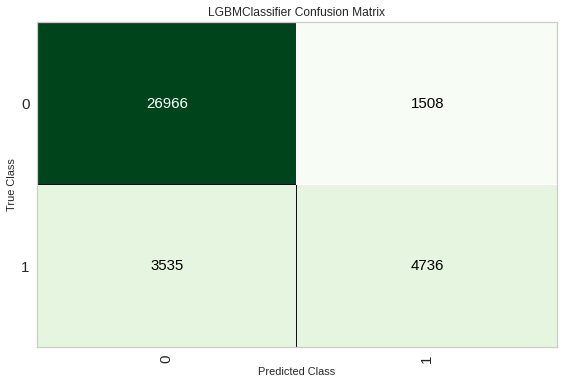

In [26]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

###Aplicação ao modelo, com 86,28% de acerto

In [27]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8628,0.8952,0.5726,0.7585,0.6526,0.5691,0.5779


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,...,Cloud9am_7.0,Cloud9am_8.0,Cloud9am_not_available,Cloud3pm_0.0,Cloud3pm_1.0,Cloud3pm_2.0,Cloud3pm_3.0,Cloud3pm_4.0,Cloud3pm_5.0,Cloud3pm_6.0,Cloud3pm_7.0,Cloud3pm_8.0,Cloud3pm_not_available,RainToday_No,RainToday_Yes,RainToday_not_available,Date_month_1,Date_month_10,Date_month_11,Date_month_12,Date_month_2,Date_month_3,Date_month_4,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_weekday_0,Date_weekday_1,Date_weekday_2,Date_weekday_3,Date_weekday_4,Date_weekday_5,Date_weekday_6,Date_is_month_end_1,Date_is_month_start_0,RainTomorrow,Label,Score
0,15.9,33.099998,0.000000,5.479686,7.616826,50.000000,9.0,26.0,66.0,31.0,1013.900024,1009.000000,21.000000,31.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.7985
1,8.5,24.299999,0.000000,5.479686,7.616826,39.000000,11.0,22.0,28.0,8.0,1021.200012,1017.799988,12.900000,22.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.9936
2,-1.6,10.800000,0.000000,5.479686,7.616826,15.000000,2.0,6.0,97.0,75.0,1021.200012,1016.599976,1.600000,10.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Yes,No,0.8108
3,10.2,21.500000,0.000000,5.479686,7.616826,19.000000,11.0,13.0,56.0,47.0,1020.500000,1017.599976,17.200001,20.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,No,No,0.9936
4,13.9,29.799999,0.000000,6.000000,11.300000,39.968357,7.0,7.0,63.0,30.0,1017.649536,1015.257324,18.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.9984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36740,20.6,29.799999,36.200001,4.200000,8.600000,33.000000,4.0,11.0,67.0,70.0,1008.799988,1008.599976,28.000000,26.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Yes,Yes,0.5733
36741,2.8,22.500000,0.000000,3.200000,7.500000,39.968357,11.0,13.0,100.0,39.0,1021.700012,1016.900024,9.000000,21.900000,0.0,0.0,0.0,0.0,0.0,0.0

###Ajuste do modelo

In [28]:
best_calib = calibrate_model( tuned_lightgbm )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8604,0.8994,0.5429,0.7619,0.6341,0.5508,0.5629
1,0.8619,0.8973,0.5545,0.7608,0.6414,0.5585,0.5692
2,0.8618,0.9014,0.5686,0.7505,0.6470,0.5631,0.5715
3,0.8646,0.9005,0.5696,0.7624,0.6521,0.5702,0.5795
4,0.8649,0.9012,0.5602,0.7709,0.6489,0.5678,0.5789
5,0.8617,0.8954,0.5558,0.7584,0.6415,0.5583,0.5686
6,0.8659,0.9022,0.5618,0.7742,0.6511,0.5706,0.5819
7,0.8675,0.9050,0.5649,0.7796,0.6551,0.5757,0.5871
8,0.8708,0.9081,0.5827,0.7816,0.6677,0.5896,0.5993
9,0.8659,0.9046,0.5728,0.7661,0.6555,0.5743,0.5837


Matrix de confusão final, indicando:
* 27163 (inicial = 26966) Verdadeiros negativos
* 4617 (inicial = 4736) Verdadeiros positivos
* 3654 (inicial = 3535) Falsos negativos
* 1311 (inicial = 1508) Falsos positivos

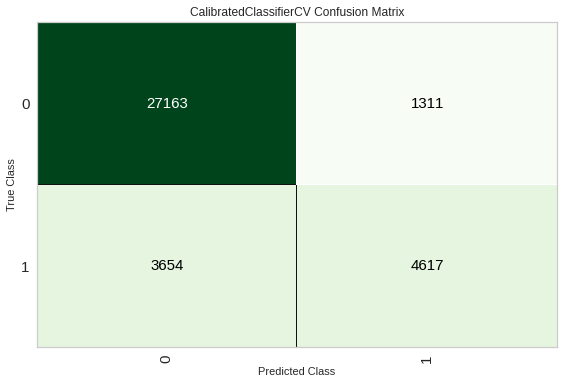

In [29]:
plot_model(best_calib, plot='confusion_matrix')

###Aplicação ao modelo, com 86,49% de acerto (anterior 86,28%)

In [30]:
predict_model(best_calib)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8649,0.8991,0.5582,0.7788,0.6503,0.5694,0.5815


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,...,Cloud9am_7.0,Cloud9am_8.0,Cloud9am_not_available,Cloud3pm_0.0,Cloud3pm_1.0,Cloud3pm_2.0,Cloud3pm_3.0,Cloud3pm_4.0,Cloud3pm_5.0,Cloud3pm_6.0,Cloud3pm_7.0,Cloud3pm_8.0,Cloud3pm_not_available,RainToday_No,RainToday_Yes,RainToday_not_available,Date_month_1,Date_month_10,Date_month_11,Date_month_12,Date_month_2,Date_month_3,Date_month_4,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_weekday_0,Date_weekday_1,Date_weekday_2,Date_weekday_3,Date_weekday_4,Date_weekday_5,Date_weekday_6,Date_is_month_end_1,Date_is_month_start_0,RainTomorrow,Label,Score
0,15.9,33.099998,0.000000,5.479686,7.616826,50.000000,9.0,26.0,66.0,31.0,1013.900024,1009.000000,21.000000,31.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.7366
1,8.5,24.299999,0.000000,5.479686,7.616826,39.000000,11.0,22.0,28.0,8.0,1021.200012,1017.799988,12.900000,22.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.9474
2,-1.6,10.800000,0.000000,5.479686,7.616826,15.000000,2.0,6.0,97.0,75.0,1021.200012,1016.599976,1.600000,10.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Yes,No,0.7315
3,10.2,21.500000,0.000000,5.479686,7.616826,19.000000,11.0,13.0,56.0,47.0,1020.500000,1017.599976,17.200001,20.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,No,No,0.9462
4,13.9,29.799999,0.000000,6.000000,11.300000,39.968357,7.0,7.0,63.0,30.0,1017.649536,1015.257324,18.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.9476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36740,20.6,29.799999,36.200001,4.200000,8.600000,33.000000,4.0,11.0,67.0,70.0,1008.799988,1008.599976,28.000000,26.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Yes,Yes,0.7142
36741,2.8,22.500000,0.000000,3.200000,7.500000,39.968357,11.0,13.0,100.0,39.0,1021.700012,1016.900024,9.000000,21.900000,0.0,0.0,0.0,0.0,0.0,0.0

In [31]:
modelo_finalizado = finalize_model(best_calib)

In [32]:
predict_model( modelo_finalizado )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.868,0.9767,0.4162,0.9934,0.5866,0.5232,0.5936


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,...,Cloud9am_7.0,Cloud9am_8.0,Cloud9am_not_available,Cloud3pm_0.0,Cloud3pm_1.0,Cloud3pm_2.0,Cloud3pm_3.0,Cloud3pm_4.0,Cloud3pm_5.0,Cloud3pm_6.0,Cloud3pm_7.0,Cloud3pm_8.0,Cloud3pm_not_available,RainToday_No,RainToday_Yes,RainToday_not_available,Date_month_1,Date_month_10,Date_month_11,Date_month_12,Date_month_2,Date_month_3,Date_month_4,Date_month_5,Date_month_6,Date_month_7,Date_month_8,Date_month_9,Date_weekday_0,Date_weekday_1,Date_weekday_2,Date_weekday_3,Date_weekday_4,Date_weekday_5,Date_weekday_6,Date_is_month_end_1,Date_is_month_start_0,RainTomorrow,Label,Score
0,15.9,33.099998,0.000000,5.479686,7.616826,50.000000,9.0,26.0,66.0,31.0,1013.900024,1009.000000,21.000000,31.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.7916
1,8.5,24.299999,0.000000,5.479686,7.616826,39.000000,11.0,22.0,28.0,8.0,1021.200012,1017.799988,12.900000,22.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.8873
2,-1.6,10.800000,0.000000,5.479686,7.616826,15.000000,2.0,6.0,97.0,75.0,1021.200012,1016.599976,1.600000,10.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Yes,No,0.7006
3,10.2,21.500000,0.000000,5.479686,7.616826,19.000000,11.0,13.0,56.0,47.0,1020.500000,1017.599976,17.200001,20.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,No,No,0.8836
4,13.9,29.799999,0.000000,6.000000,11.300000,39.968357,7.0,7.0,63.0,30.0,1017.649536,1015.257324,18.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,No,0.8880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36740,20.6,29.799999,36.200001,4.200000,8.600000,33.000000,4.0,11.0,67.0,70.0,1008.799988,1008.599976,28.000000,26.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Yes,Yes,0.5101
36741,2.8,22.500000,0.000000,3.200000,7.500000,39.968357,11.0,13.0,100.0,39.0,1021.700012,1016.900024,9.000000,21.900000,0.0,0.0,0.0,0.0,0.0,0.0

In [33]:
from joblib import dump, load

dump( modelo_finalizado, '/content/modelo_finalizado.automl' )

['/content/modelo_finalizado.automl']